In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from sklearn.cluster import KMeans

import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures

In [3]:
mask = np.load(r"/home/k21208334/calcium_analyses/data/dowsampled_tight_mask.npy")
good_indices = np.ravel(mask)

In [4]:
h=300
w=304
H=50 # this is the size of downsampling. We have to find a better way to do this
W=51
start = 0
end = 25000

names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]

n_comp = 10 # i choose this n of components because it's the most convincing

In [5]:
signals = np.load('/home/k21208334/calcium_analyses/data/ICA/signals_n=' + str(n_comp) + '.npy')
components = np.load('/home/k21208334/calcium_analyses/data/ICA/components_n=' + str(n_comp) + '.npy')

In [6]:
# For each component, I compare each ICA component absolute amplitude and I do walking vs non walking

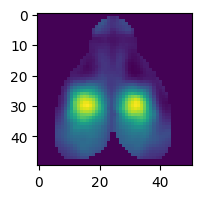

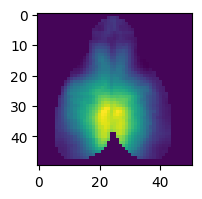

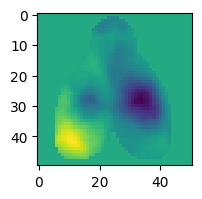

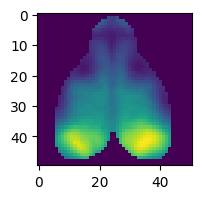

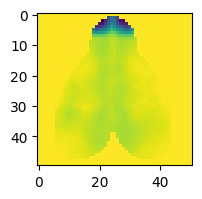

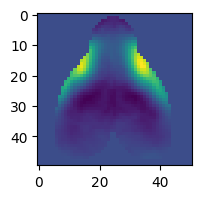

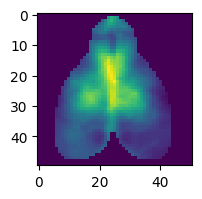

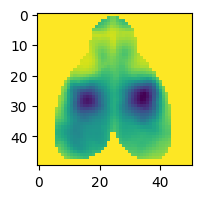

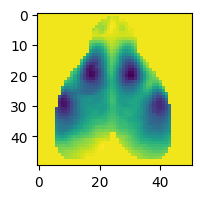

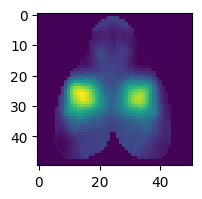

In [7]:
for i in range(n_comp):
    fig = connectivity_measures.show_array(components[:,i],H,W,good_indices)
    fig.set_size_inches(2,2)

In [8]:
# now do ICA clustering on raw amplitude signals exactly the same way as LEiDA clustering

In [9]:
signals.shape

(300000, 10)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

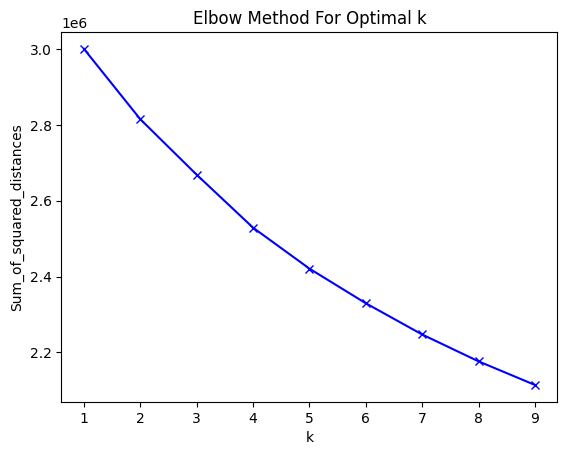

In [11]:
# plot elbow method to see number of clusters

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(signals)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [8]:
# we decide that our k is 5
k = 8

km = KMeans(n_clusters=k)
km = km.fit(signals)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
# let's define fractional occupancies. REALITY is just a dream which is good enough to make us survive.

n_individuals = len(names+names_knock)
fractional_occupancies_walk = np.zeros((n_individuals,k))
fractional_occupancies_rest = np.zeros((n_individuals,k))
fractional_occupancies_all = np.zeros((n_individuals,k))
avg_abs_speed = np.zeros((n_individuals,1))

for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]==j
        fractional_occupancies_walk[i,j] = np.sum(timeseries_labels[walking])/len(timeseries_labels[walking])
        fractional_occupancies_rest[i,j] = np.sum(timeseries_labels[~walking])/len(timeseries_labels[~walking])
        fractional_occupancies_all[i,j] = np.sum(timeseries_labels)/end
    avg_abs_speed[i] = np.mean(np.abs(np.load('/home/k21208334/calcium_analyses/data/raw_speed/'+name+'.npy')))

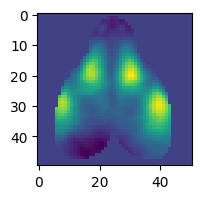

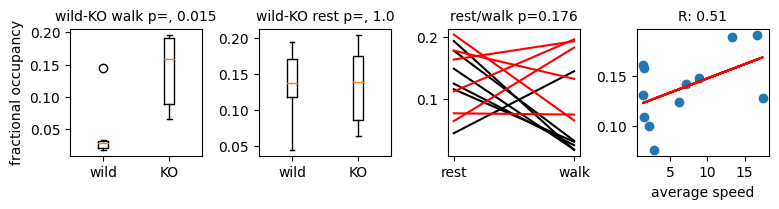

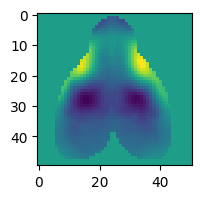

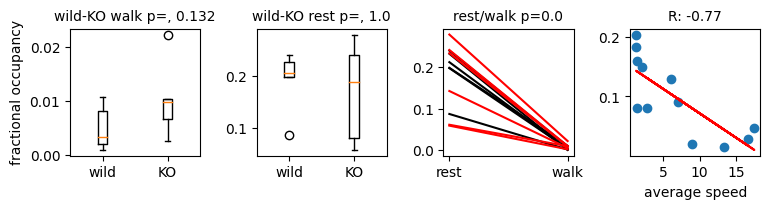

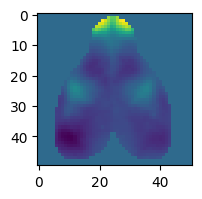

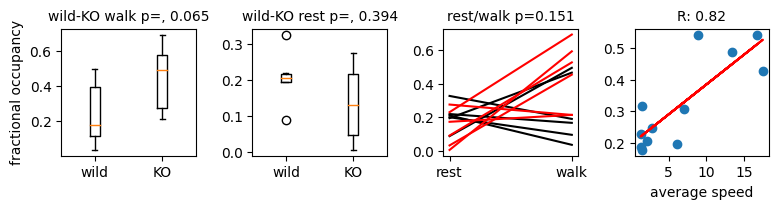

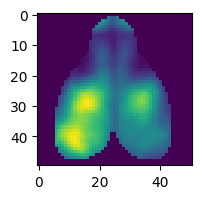

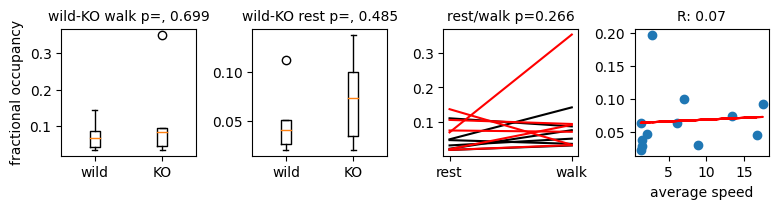

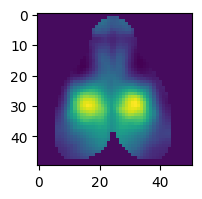

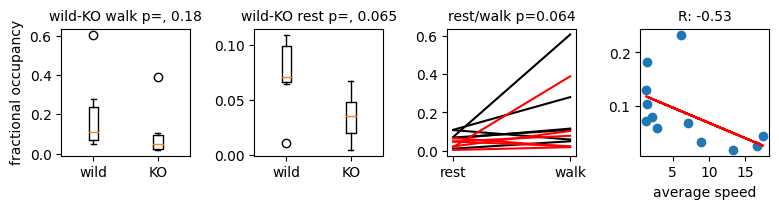

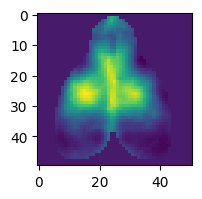

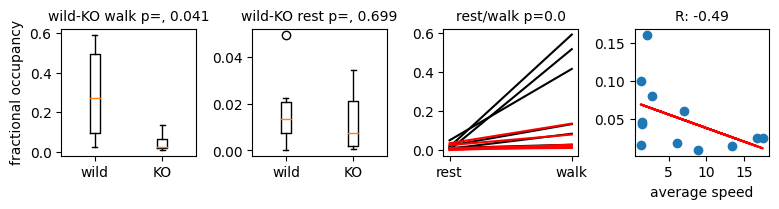

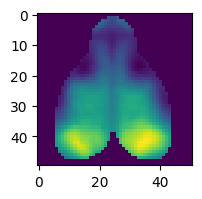

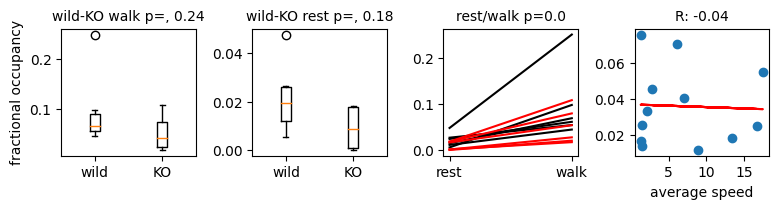

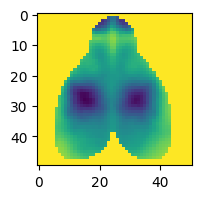

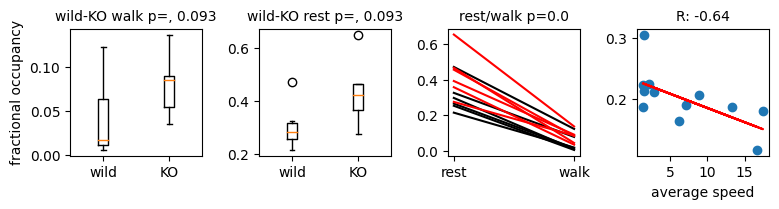

In [11]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon


cluster_centers = km.cluster_centers_
centroids = np.dot(components,cluster_centers.T)

for i,centroid in enumerate(centroids.T):
    fig = connectivity_measures.show_array(centroid,H,W,good_indices)
    fig.set_size_inches(2,2)
    
    fig,ax = plt.subplots(1,4)
    fig.set_size_inches(8,2)
    ax[0].boxplot([fractional_occupancies_walk[0:6,i],fractional_occupancies_walk[6:12,i]])
    test = mannwhitneyu(fractional_occupancies_walk[0:6,i],fractional_occupancies_walk[6:12,i])
    pvalue = test.pvalue
    ax[0].set_title('wild-KO walk p=, '+str(round(pvalue,3)),fontsize=10)
    ax[0].set_xticks([1,2], ['wild','KO'])
    ax[0].set_ylabel('fractional occupancy')
    
    ax[1].boxplot([fractional_occupancies_rest[0:6,i],fractional_occupancies_rest[6:12,i]])
    test = mannwhitneyu(fractional_occupancies_rest[0:6,i],fractional_occupancies_rest[6:12,i])
    pvalue = test.pvalue
    ax[1].set_title('wild-KO rest p=, '+str(round(pvalue,3)),fontsize=10)
    ax[1].set_xticks([1,2], ['wild','KO'])
    
    # try also statistics on walk vs non walk as a control...
    ax[2].plot([fractional_occupancies_rest[0:6,i],fractional_occupancies_walk[0:6,i]],color='black')
    ax[2].plot([fractional_occupancies_rest[6:12,i],fractional_occupancies_walk[6:12,i]],color='red')
    test = wilcoxon(fractional_occupancies_rest[:,i],fractional_occupancies_walk[:,i])
    pvalue = test.pvalue
    ax[2].set_title('rest/walk p='+str(round(pvalue,3)),fontsize=10)
    ax[2].set_xticks([0,1], ['rest','walk'])
    fig.tight_layout()
    
    x = np.squeeze(avg_abs_speed.T)
    y = fractional_occupancies_all[:,i]
    ax[3].scatter(x,y)
    slope, intercept = np.polyfit(x, y, 1)
    corr_coef = np.corrcoef(x, y)[0, 1]
    # Add the linear fit line to the plot
    ax[3].plot(x, slope*x + intercept, color='red')
    ax[3].set_title(f'R: {corr_coef:.2f}',fontsize=10)
    ax[3].set_xlabel('average speed')
    


In [12]:
# DEFINITION OF THE FUNCTION. WHEN READY, TRANSFER TO LIBRARY
def compute_dwell_time(labels,walking,threshold):
    dwell_times = []
    walking_bouts = widefield_utils.get_connected_components(walking,threshold)
    for bout in walking_bouts:
        labels_bout = widefield_utils.get_connected_components(labels[bout],0) # this threshold at the moment is 0, whatever duration is accepted
        for element in labels_bout:
            dwell_times.append(len(element))
    if len(dwell_times)>0:
        result = np.mean(dwell_times)
    else:
        result = 0
    return result

In [13]:
# let us now define dwell time. With a similar code. When everything is set and well done, we transfer to functions

threshold = 36 # i want a bout of at least 1 second in order to consider it as a reliable walk/rest period

n_individuals = len(names+names_knock)
dwell_times_walk = np.zeros((n_individuals,k))
dwell_times_rest = np.zeros((n_individuals,k))
dwell_times_all = np.zeros((n_individuals,k))
avg_abs_speed = np.zeros((n_individuals,1))

for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]==j
        dwell_times_walk[i,j] = compute_dwell_time(timeseries_labels,walking,threshold)
        dwell_times_rest[i,j] = compute_dwell_time(timeseries_labels,~walking,threshold)
        dwell_times_all[i,j] = compute_dwell_time(timeseries_labels,np.array([True] * end),threshold)
    avg_abs_speed[i] = np.mean(np.abs(np.load('/home/k21208334/calcium_analyses/data/raw_speed/'+name+'.npy')))

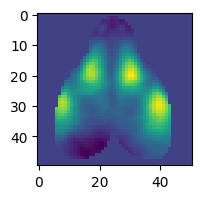

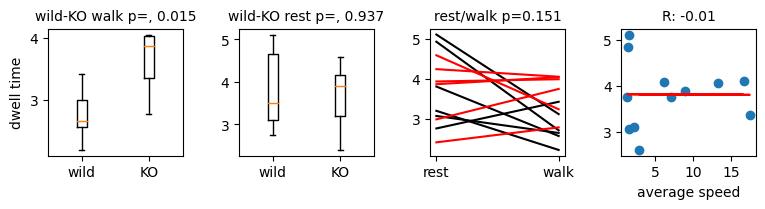

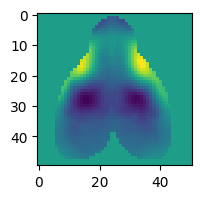

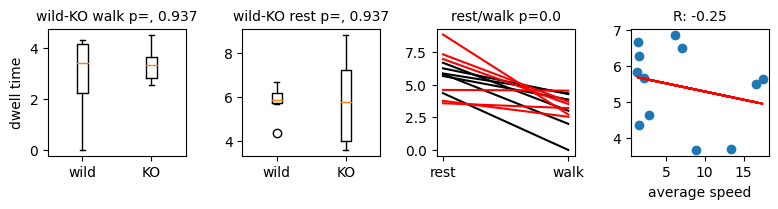

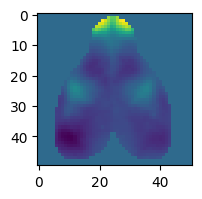

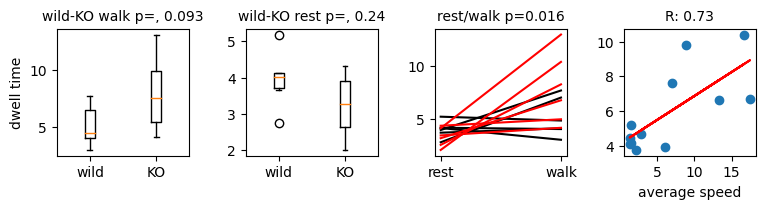

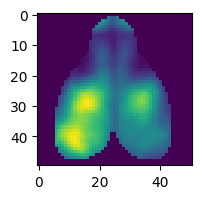

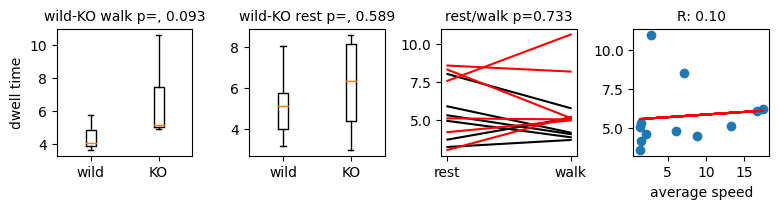

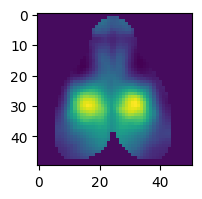

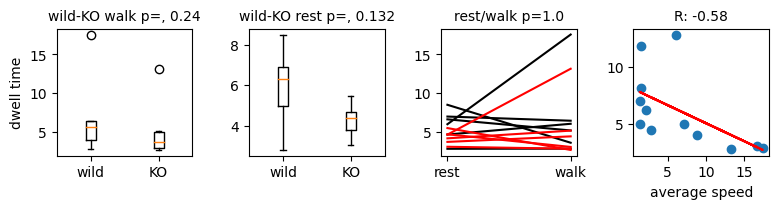

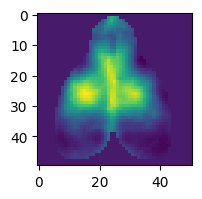

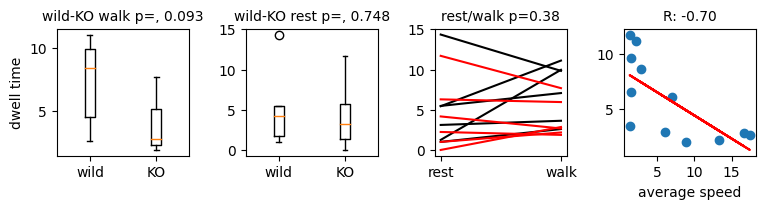

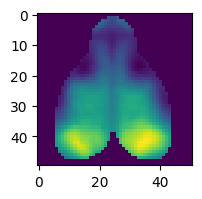

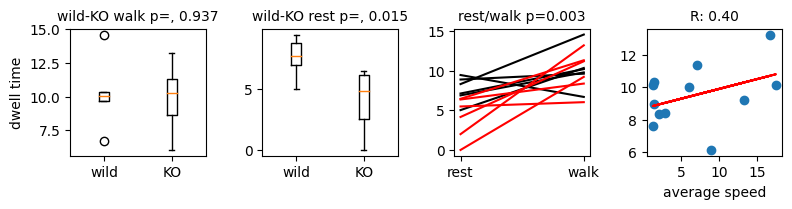

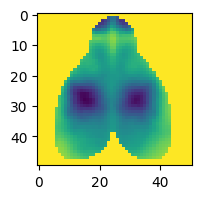

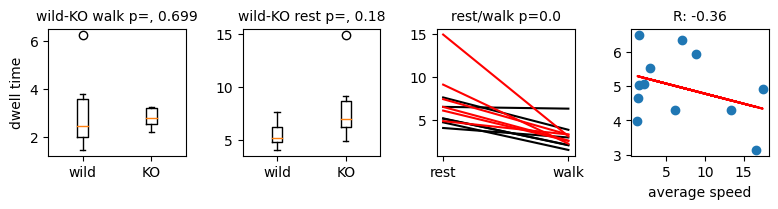

In [14]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon


cluster_centers = km.cluster_centers_
centroids = np.dot(components,cluster_centers.T)

for i,centroid in enumerate(centroids.T):
    fig = connectivity_measures.show_array(centroid,H,W,good_indices)
    fig.set_size_inches(2,2)
    
    fig,ax = plt.subplots(1,4)
    fig.set_size_inches(8,2)
    ax[0].boxplot([dwell_times_walk[0:6,i],dwell_times_walk[6:12,i]])
    test = mannwhitneyu(dwell_times_walk[0:6,i],dwell_times_walk[6:12,i])
    pvalue = test.pvalue
    ax[0].set_title('wild-KO walk p=, '+str(round(pvalue,3)),fontsize=10)
    ax[0].set_xticks([1,2], ['wild','KO'])
    ax[0].set_ylabel('dwell time')
    
    ax[1].boxplot([dwell_times_rest[0:6,i],dwell_times_rest[6:12,i]])
    test = mannwhitneyu(dwell_times_rest[0:6,i],dwell_times_rest[6:12,i])
    pvalue = test.pvalue
    ax[1].set_title('wild-KO rest p=, '+str(round(pvalue,3)),fontsize=10)
    ax[1].set_xticks([1,2], ['wild','KO'])
    
    # try also statistics on walk vs non walk as a control...
    ax[2].plot([dwell_times_rest[0:6,i],dwell_times_walk[0:6,i]],color='black')
    ax[2].plot([dwell_times_rest[6:12,i],dwell_times_walk[6:12,i]],color='red')
    test = wilcoxon(dwell_times_rest[:,i],dwell_times_walk[:,i])
    pvalue = test.pvalue
    ax[2].set_title('rest/walk p='+str(round(pvalue,3)),fontsize=10)
    ax[2].set_xticks([0,1], ['rest','walk'])
    fig.tight_layout()
    
    x = np.squeeze(avg_abs_speed.T)
    y = dwell_times_all[:,i]
    ax[3].scatter(x,y)
    slope, intercept = np.polyfit(x, y, 1)
    corr_coef = np.corrcoef(x, y)[0, 1]
    # Add the linear fit line to the plot
    ax[3].plot(x, slope*x + intercept, color='red')
    ax[3].set_title(f'R: {corr_coef:.2f}',fontsize=10)
    ax[3].set_xlabel('average speed')

In [15]:
# create graph with transition probabilities. Each row is where I start, each column is where I arrive 
timeseries_labels = km.labels_

transition_prob = np.zeros((k,k))
time_total = len(timeseries_labels)

for i in range(time_total-1):
    transition_prob[timeseries_labels[i],timeseries_labels[i+1]] += 1

#normalize each row with respect to number of observed transitions

for i in range(k):
    transition_prob[i,:] /= np.sum(timeseries_labels==i)


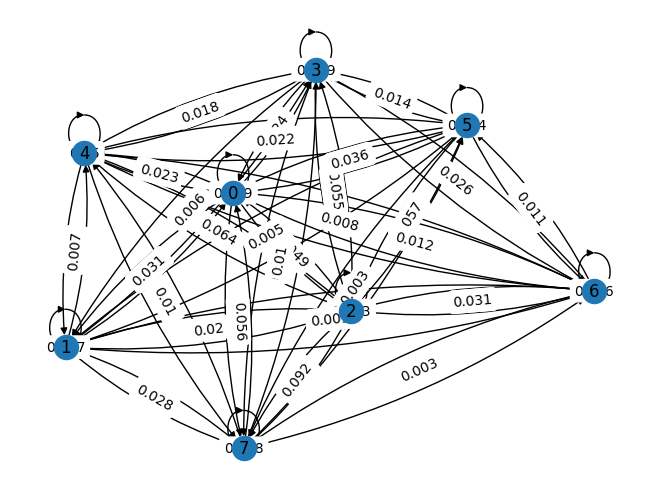

In [16]:
# draw network with it

import networkx as nx

G = nx.DiGraph()
for i in range(len(transition_prob)):
    for j in range(len(transition_prob)):
        if transition_prob[i][j] != 0:
            G.add_edge(i, j, weight=round(transition_prob[i][j],3))
            
       
            
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True,arrows=True,
       connectionstyle='arc3, rad = 0.1')
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

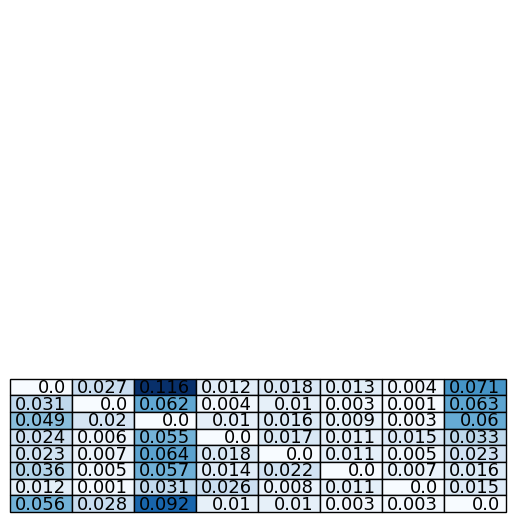

In [17]:
np.fill_diagonal(transition_prob, 0) #c'è una cosa da discutere su python: certe funzioni alterano il content!



# Set the color map
cmap = plt.cm.Blues
colors = transition_prob/transition_prob.max()
# Create a figure and axis object
fig, ax = plt.subplots()
# Create a table object and add it to the axis
table = ax.table(cellText=transition_prob.round(3),
                 cellColours=cmap(colors))
# Set the font size of the table text
table.set_fontsize(14)
# Remove the axis ticks and labels
ax.axis('off')

# Show the plot
plt.show()

# Analysis of ICA transpose 

In [ ]:
signals = np.load('/home/k21208334/calcium_analyses/data/ICA/ICA_T_signals_n=' + str(n_comp) + '.npy')
components = np.load('/home/k21208334/calcium_analyses/data/ICA/ICA_T_components_n=' + str(n_comp) + '.npy')

In [ ]:
fare il check delle dimensioni per fare eventuali trasposti!

In [ ]:
# we decide that our k is 5
k = 8

km = KMeans(n_clusters=k)
km = km.fit(signals)

In [ ]:
# let's define fractional occupancies. REALITY is just a dream which is good enough to make us survive.

n_individuals = len(names+names_knock)
fractional_occupancies_walk = np.zeros((n_individuals,k))
fractional_occupancies_rest = np.zeros((n_individuals,k))
fractional_occupancies_all = np.zeros((n_individuals,k))
avg_abs_speed = np.zeros((n_individuals,1))

for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]==j
        fractional_occupancies_walk[i,j] = np.sum(timeseries_labels[walking])/len(timeseries_labels[walking])
        fractional_occupancies_rest[i,j] = np.sum(timeseries_labels[~walking])/len(timeseries_labels[~walking])
        fractional_occupancies_all[i,j] = np.sum(timeseries_labels)/end
    avg_abs_speed[i] = np.mean(np.abs(np.load('/home/k21208334/calcium_analyses/data/raw_speed/'+name+'.npy')))

In [ ]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon


cluster_centers = km.cluster_centers_
centroids = np.dot(components,cluster_centers.T)

for i,centroid in enumerate(centroids.T):
    fig = connectivity_measures.show_array(centroid,H,W,good_indices)
    fig.set_size_inches(2,2)
    
    fig,ax = plt.subplots(1,4)
    fig.set_size_inches(8,2)
    ax[0].boxplot([fractional_occupancies_walk[0:6,i],fractional_occupancies_walk[6:12,i]])
    test = mannwhitneyu(fractional_occupancies_walk[0:6,i],fractional_occupancies_walk[6:12,i])
    pvalue = test.pvalue
    ax[0].set_title('wild-KO walk p=, '+str(round(pvalue,3)),fontsize=10)
    ax[0].set_xticks([1,2], ['wild','KO'])
    ax[0].set_ylabel('fractional occupancy')
    
    ax[1].boxplot([fractional_occupancies_rest[0:6,i],fractional_occupancies_rest[6:12,i]])
    test = mannwhitneyu(fractional_occupancies_rest[0:6,i],fractional_occupancies_rest[6:12,i])
    pvalue = test.pvalue
    ax[1].set_title('wild-KO rest p=, '+str(round(pvalue,3)),fontsize=10)
    ax[1].set_xticks([1,2], ['wild','KO'])
    
    # try also statistics on walk vs non walk as a control...
    ax[2].plot([fractional_occupancies_rest[0:6,i],fractional_occupancies_walk[0:6,i]],color='black')
    ax[2].plot([fractional_occupancies_rest[6:12,i],fractional_occupancies_walk[6:12,i]],color='red')
    test = wilcoxon(fractional_occupancies_rest[:,i],fractional_occupancies_walk[:,i])
    pvalue = test.pvalue
    ax[2].set_title('rest/walk p='+str(round(pvalue,3)),fontsize=10)
    ax[2].set_xticks([0,1], ['rest','walk'])
    fig.tight_layout()
    
    x = np.squeeze(avg_abs_speed.T)
    y = fractional_occupancies_all[:,i]
    ax[3].scatter(x,y)
    slope, intercept = np.polyfit(x, y, 1)
    corr_coef = np.corrcoef(x, y)[0, 1]
    # Add the linear fit line to the plot
    ax[3].plot(x, slope*x + intercept, color='red')
    ax[3].set_title(f'R: {corr_coef:.2f}',fontsize=10)
    ax[3].set_xlabel('average speed')